In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import keras_tuner as kt

In [3]:
np.set_printoptions(precision=20, suppress=True)

my_data = np.genfromtxt('ML-CUP24-TR.csv', delimiter=',')
X = my_data[:, 1:13]
y = my_data[:, 13:16]
print(X.shape, y.shape)

#print(X)
#print(y)

# Suddividi i dati in train (60%) e temp (40%) (HOLDOUT)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)

# Suddividi temp in validation (20%) e test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Normalizza i dati
scaler_X = StandardScaler().fit(X_train)
scaler_y = StandardScaler().fit(y_train)

X_train = scaler_X.transform(X_train)
X_val = scaler_X.transform(X_val)
X_test = scaler_X.transform(X_test)

y_train = scaler_y.transform(y_train)
y_val = scaler_y.transform(y_val)
y_test = scaler_y.transform(y_test)

# Funzione di attivazione RBF con TensorFlow
def rbf_activation(x, centers, gamma=1.0):
    # Calcola la distanza euclidea tra l'input e i centri
    diff = x[:, np.newaxis, :] - centers
    dist_sq = tf.reduce_sum(tf.square(diff), axis=-1)  # Usa tf.reduce_sum invece di np.sum
    return tf.exp(-gamma * dist_sq)

# Creare il modello
def build_rbf_model(input_dim, output_dim, n_centers=10, gamma=1.0):
    model = models.Sequential()

    # Layer di input: utilizza 'shape' invece di 'input_dim'
    model.add(layers.InputLayer(shape=(input_dim,)))

    # Layer nascosta con attivazione RBF (calcola distanza dal centro)
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)  # Centri randomici
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))

    # Layer di output con una dimensione pari al numero di target (3 in questo caso: x, y, z)
    model.add(layers.Dense(output_dim))

    return model

(250, 12) (250, 3)


## 2try_test1

Trial 90 Complete [00h 00m 03s]
val_loss: 0.37859076261520386

Best val_loss So Far: 0.3015846908092499
Total elapsed time: 00h 02m 16s
Epoch 1/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 1.1545 - mse: 1.1545Epoch 1: Loss=0.9623742699623108, Val_Loss=0.961564838886261
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0112 - mse: 1.0112 - val_loss: 0.9616 - val_mse: 0.9616
Epoch 2/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9472 - mse: 0.9472Epoch 2: Loss=0.8880936503410339, Val_Loss=0.9039135575294495
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8719 - mse: 0.8719 - val_loss: 0.9039 - val_mse: 0.9039
Epoch 3/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6572 - mse: 0.6572Epoch 3: Loss=0.8308131694793701, Val_Loss=0.8590498566627502
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8061 - mse: 0.8061 - val_loss: 0.8590 - val_mse: 0.8590
Epoch 4/200
 1/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8754 - mse: 0.8754Epoch 4: Loss=0.7816442847251892, Val_Loss=0.

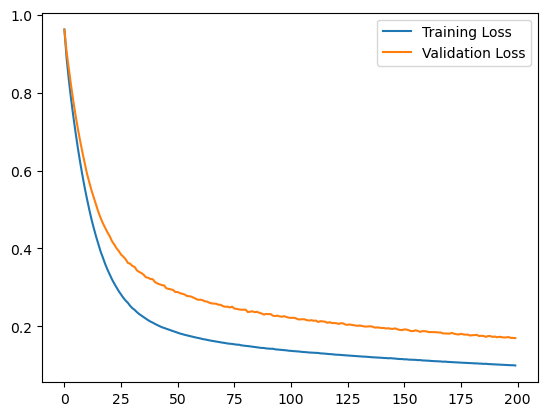

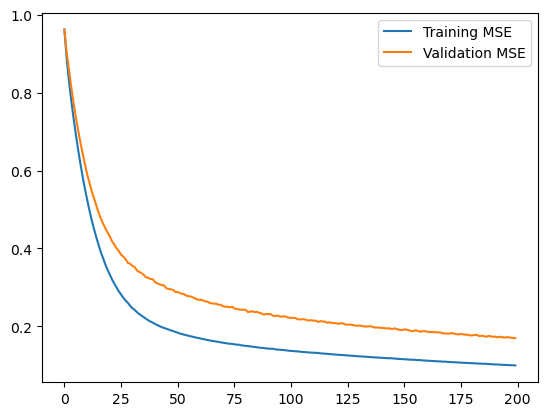

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0972 - mse: 0.0972 
Test Loss: 0.09908042848110199
Test MSE: 0.09908042848110199
Top hyperparameter configurations:
    n_centers  gamma  learning_rate  batch_size  tuner/epochs  \
10        110  0.112         0.0014          14            50   
7         114  0.107         0.0015           6            50   
2         116  0.109         0.0016           6            50   
3         118  0.110         0.0012          12            50   
1         120  0.112         0.0017          11            50   

    tuner/initial_epoch  tuner/bracket  tuner/round  test_loss  test_mse  \
10                    0              0            0   0.099080  0.099080   
7                    17              2            2   0.303330  0.303330   
2                    17              1            1   0.326913  0.326913   
3                     0              0            0   0.403366  0.403366   
1                    17              3            3   0.412649  0.

In [14]:
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

# Function to compute RBF activation (placeholder, implement your logic)
def rbf_activation(x, centers, gamma):
    # Example implementation for RBF activation
    return tf.exp(-gamma * tf.reduce_sum(tf.square(x[:, None, :] - centers), axis=-1))

# Function to build the model for Keras Tuner
def build_rbf_model_tuner(hp):
    input_dim = 12  # Number of input features
    output_dim = 3  # Number of targets (x, y, z)

    n_centers = hp.Int('n_centers', min_value=100, max_value=120, step=1)
    gamma = hp.Float('gamma', min_value=0.1, max_value=0.12, step=0.001)
    learning_rate = hp.Float('learning_rate', min_value=0.0001, max_value=0.002, step=0.0001)
    batch_size = hp.Int('batch_size', min_value=5, max_value=20, step=1)

    # Create the model
    model = models.Sequential()
    model.add(layers.InputLayer(input_shape=(input_dim,)))

    # RBF Layer
    centers = tf.Variable(np.random.randn(n_centers, input_dim), dtype=tf.float32)
    model.add(layers.Lambda(lambda x: rbf_activation(x, centers, gamma)))

    # Output Layer
    model.add(layers.Dense(output_dim))

    # Optimizer
    optimizer = Adam(learning_rate=learning_rate)

    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mse'])

    return model

# Callback to display progress after each epoch
class PrintTrainingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}: Loss={logs['loss']}, Val_Loss={logs['val_loss']}")

# Hyperparameter tuning
results = []  # To store hyperparameters and results

def record_results(hyperparameters, test_loss, test_mse, val_loss):
    entry = hyperparameters.copy()
    entry['test_loss'] = test_loss
    entry['test_mse'] = test_mse
    entry['val_loss'] = val_loss
    results.append(entry)

tuner = kt.Hyperband(
    build_rbf_model_tuner,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    overwrite=True
)

# Search for the best hyperparameters
tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]
)

# Get all tested hyperparameters
all_hps = tuner.get_best_hyperparameters(num_trials=10)  # Modify as needed
for hp in all_hps:
    best_model = tuner.hypermodel.build(hp)
    history = best_model.fit(
        X_train, y_train,
        epochs=10,  # Use a small number to quickly evaluate
        batch_size=hp.get('batch_size'),
        validation_data=(X_val, y_val),
        verbose=0
    )

    # Evaluate on test set
    test_loss, test_mse = best_model.evaluate(X_test, y_test, verbose=0)
    val_loss = min(history.history['val_loss'])

    # Record the results
    record_results(hp.values, test_loss, test_mse, val_loss)

# Plot the results for the best configuration
best_hp = tuner.get_best_hyperparameters(1)[0]
best_model = tuner.hypermodel.build(best_hp)
history = best_model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=best_hp['batch_size'],
    validation_data=(X_val, y_val),
    callbacks=[PrintTrainingCallback()]
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.legend()
plt.show()

# Evaluate the best model on test data
test_loss, test_mse = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test MSE: {test_mse}")

val_loss = min(history.history['val_loss'])
record_results(best_hp.values, test_loss, test_mse, val_loss)

# Save results to a CSV file
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='test_mse')  # Sort by test MSE
results_df.to_csv('Testsdata/2try_test12_data.csv', index=False)

# Print the sorted results
print("Top hyperparameter configurations:")
print(results_df.head())